In [174]:
! pip install spacy
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4
!pip install textblob

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 330.3 kB/s eta 0:00:39
     --------------------------------------- 0.0/12.8 MB 262.6 kB/s eta 0:00:49
     --------------------------------------- 0.1/12.8 MB 327.7 kB/s eta 0:00:39
     --------------------------------------- 0.1/12.8 MB 381.3 kB/s eta 0:00:34
     --------------------------------------- 0.2/12.8 MB 612.6 kB/s eta 0:00:21
      -------------------------------------- 0.2/12.8 MB 728.8 kB/s eta 0:00:18
      -------------------------------------- 0.3/12.8 MB 911.0 kB/s eta 0:00:14
      -------------------------------------- 0.3/12.8 MB 911.0 kB/s eta 0:00:14
      -------------------------------------- 0.3/12.8 MB 811.9 kB/s eta 0:00:16
      -------------------------------------- 0.3/12.8 MB 811.9 kB/s eta 0:00:16
     - ------------------------------------- 0.4/12.8 MB 719.3 kB/s eta 0:00:18
     - ------------------------------------- 0.4

In [146]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

In [147]:
df = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_sentiment.csv',header=None, index_col=0)
df.head()

,1,2,3
0,,,
2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2401,Borderlands,Positive,im coming on borderlands and i will murder you...
2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [148]:
df = df[[2,3]].reset_index(drop=True)

In [149]:
df.columns = ['sentiment', 'text']
df.head(3)

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  75682 non-null  object
 1   text       74996 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [151]:
df.isnull().sum()
df.dropna(inplace=True)
 

In [152]:
sum (df['text'].apply(len)>5),sum (df['text'].apply(len)<=5)

(72883, 2113)

In [153]:
print(df.shape)
df = df[df['text'].apply(len)>5] 
print(df.shape)

(74996, 2)
(72883, 2)


In [154]:
df['sentiment'].value_counts()

sentiment
Negative      22020
Positive      20186
Neutral       17899
Irrelevant    12778
Name: count, dtype: int64

In [155]:
import preprocess_kgptalkie as ps

df.columns

Index(['sentiment', 'text'], dtype='object')

In [156]:
df = ps.get_basic_features(df)

In [157]:
df.columns

Index(['sentiment', 'text', 'char_counts', 'word_counts', 'avg_wordlength',
       'stopwords_counts', 'hashtag_counts', 'mentions_counts',
       'digits_counts', 'uppercase_counts'],
      dtype='object')

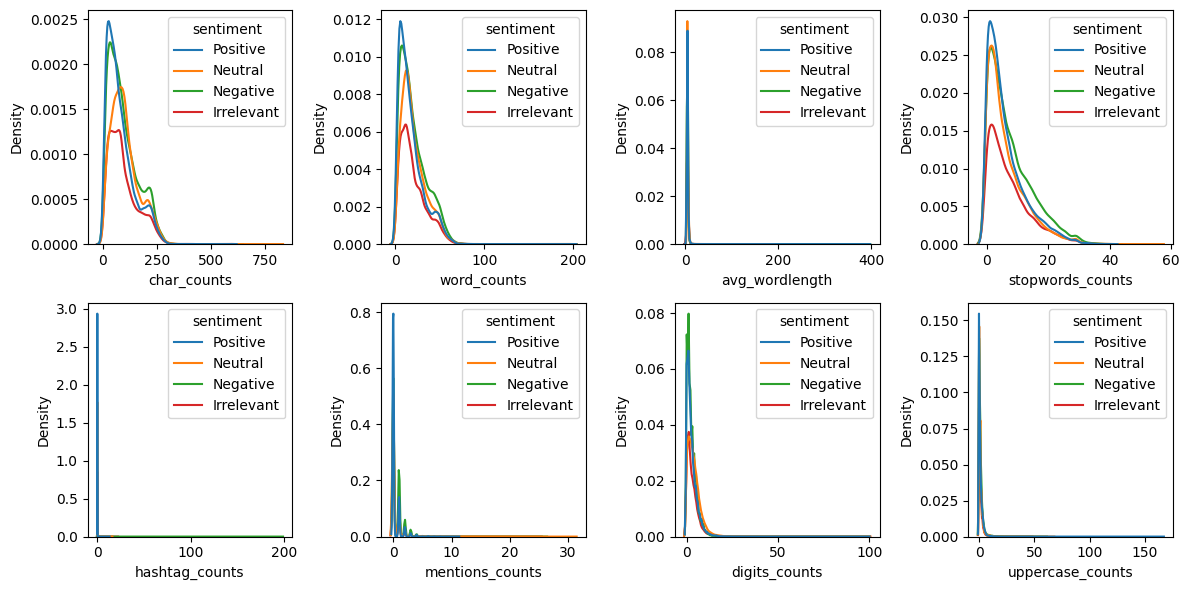

In [158]:
df.head()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
num_cols = df.select_dtypes(include='number').columns

for index, col in enumerate(num_cols):
    plt.subplot(2,4, index+1)
    sns.kdeplot(data=df, x=col, hue="sentiment",fill=False)

plt.tight_layout()
plt.show()
    

<Axes: ylabel='count'>

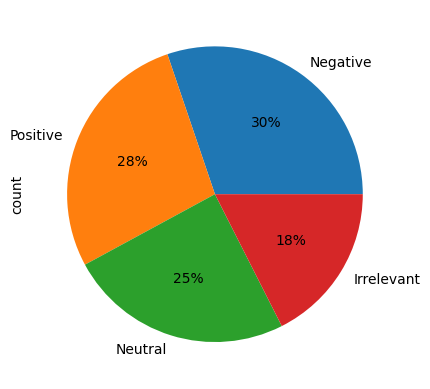

In [159]:
df['sentiment'].value_counts().plot(kind='pie',autopct="%1.0f%%")

In [160]:
## wordcloud visuliazation
!pip install wordcloud

In [161]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

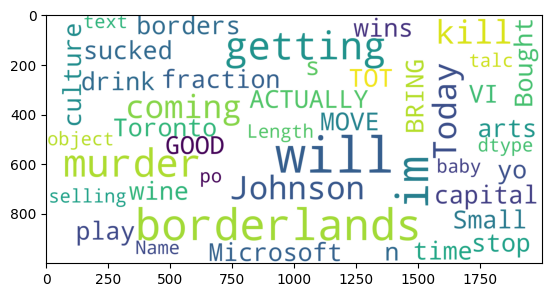

In [162]:
wordcloud = WordCloud(background_color='white',stopwords=stopwords,
                      max_words=300, max_font_size=40, scale=5).generate(str(df['text']))


plt.imshow(wordcloud)



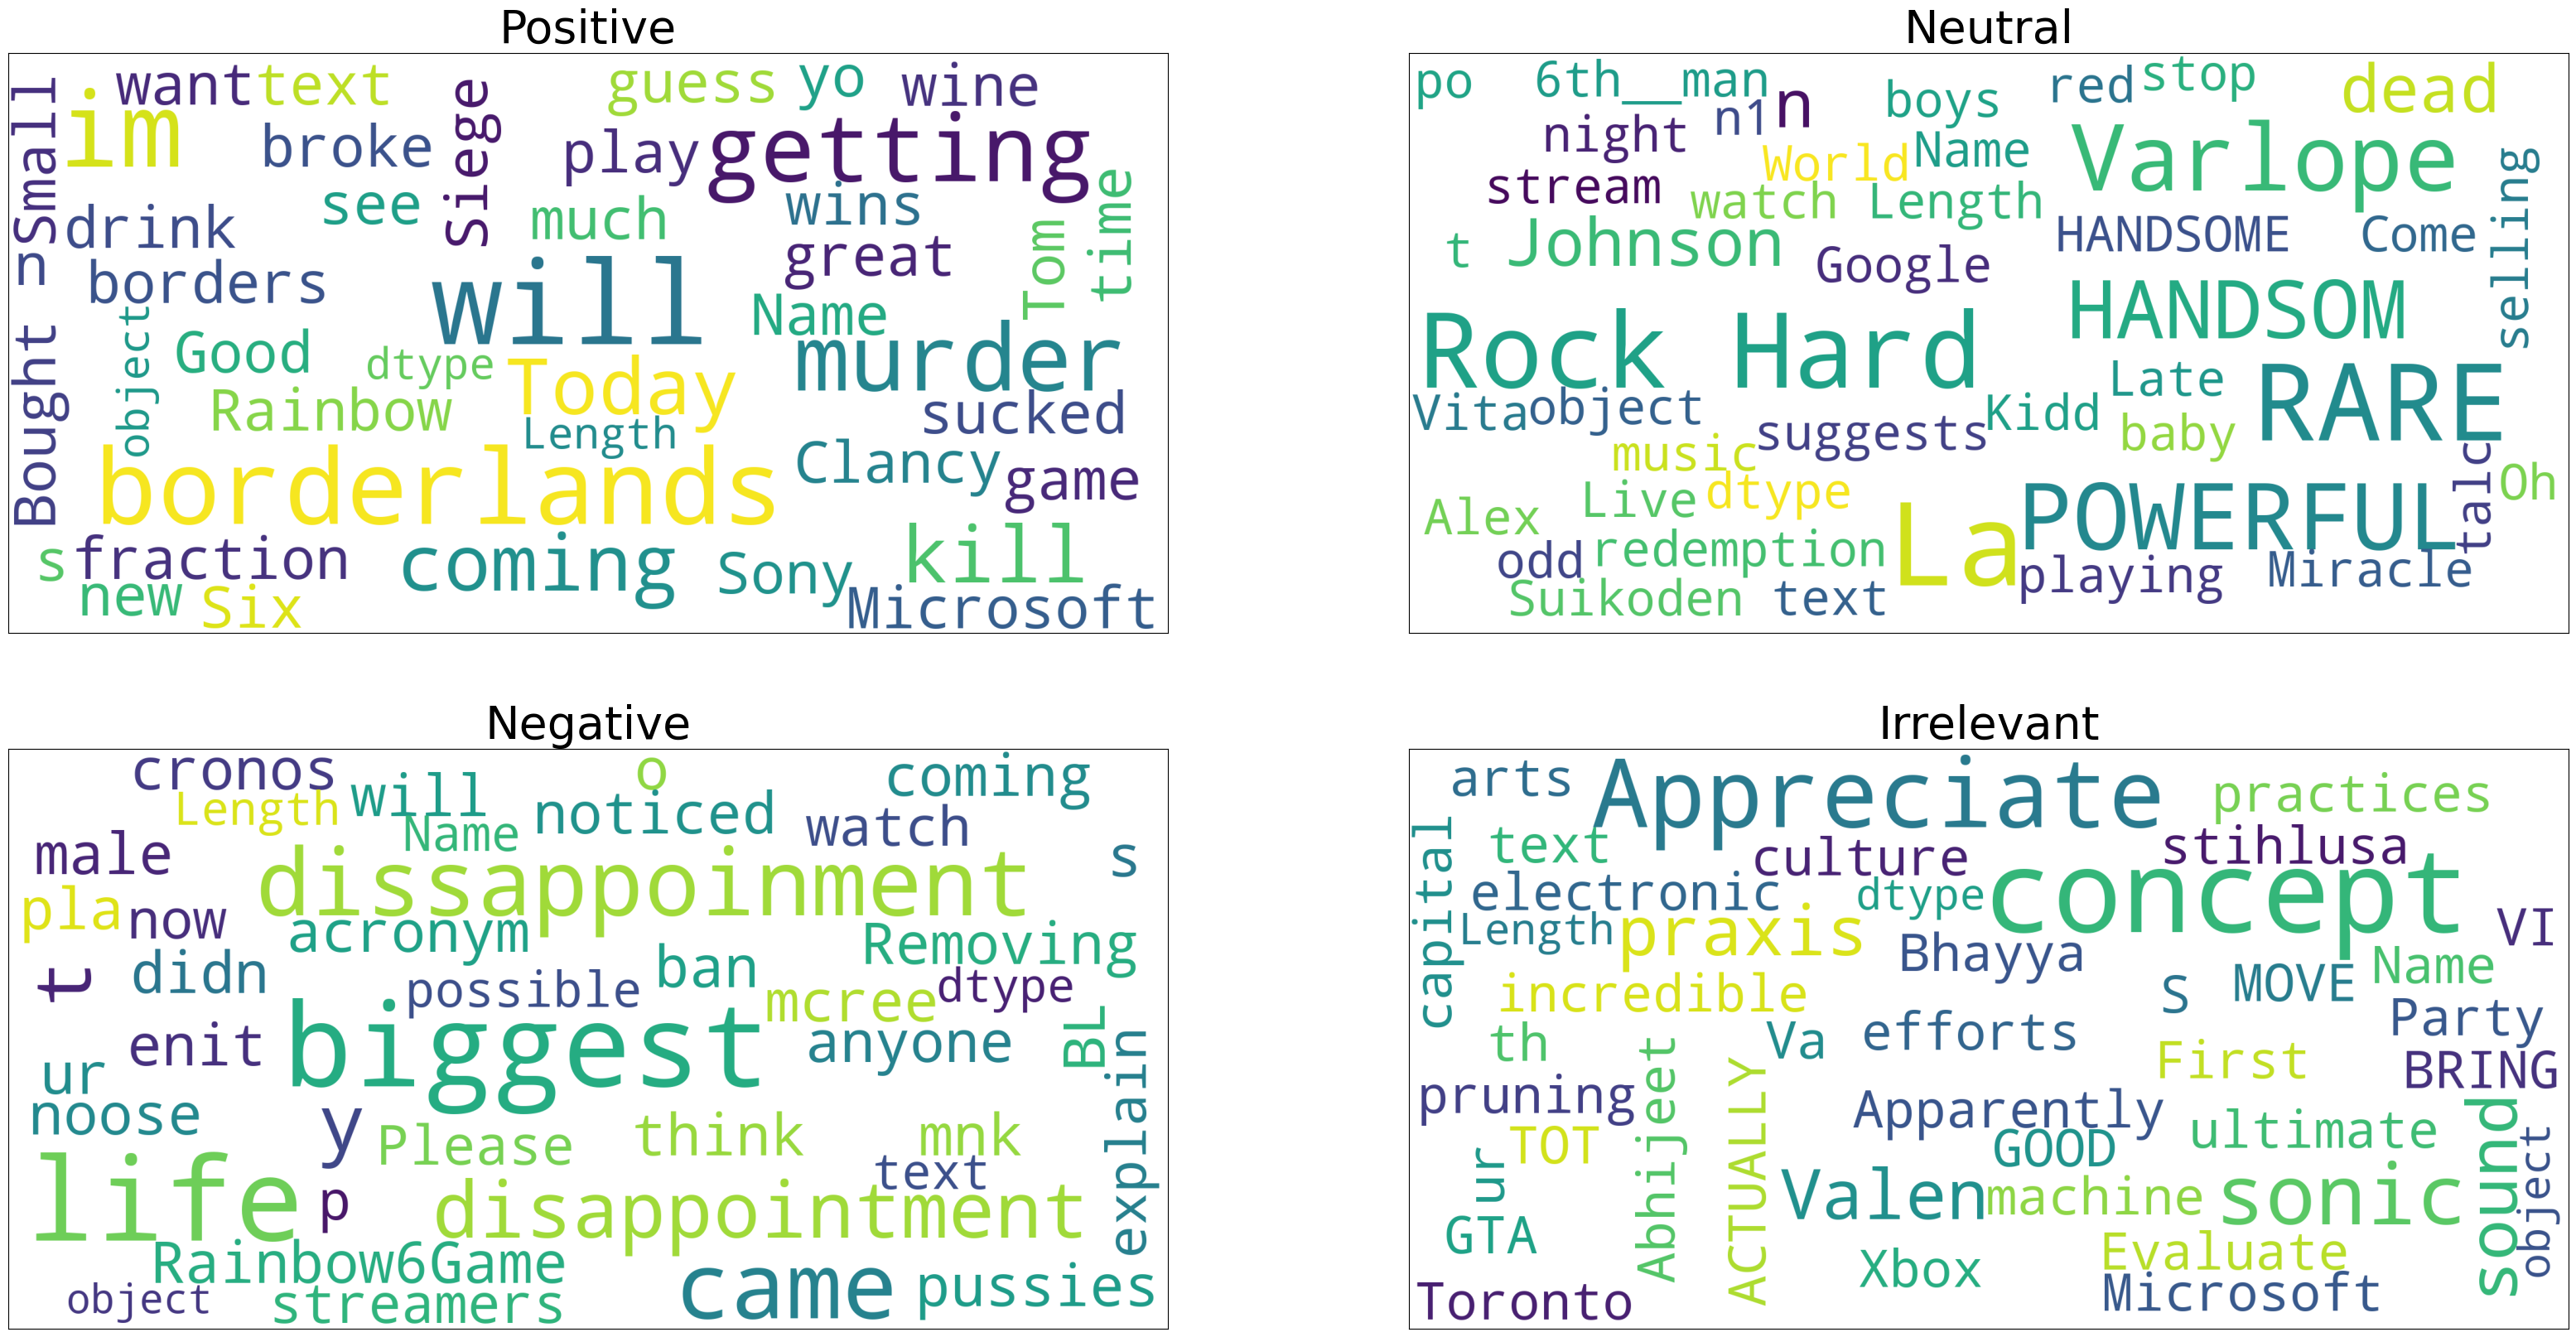

In [163]:
plt.figure(figsize=(40,20))

for index, sent in enumerate(df['sentiment'].unique()):
    plt.subplot(2,2, index+1)

    data = df[df['sentiment']==sent]['text']
    wordcloud = WordCloud(background_color='white',stopwords=stopwords,
                      max_words=300, max_font_size=40, scale=5).generate(str(data))


    plt.imshow(wordcloud)
    plt.xticks([])
    plt.yticks([])
    plt.title(sent, fontsize=40)

    

In [164]:
###DATA CLEANING


In [165]:
df['text'] = df['text'].apply(lambda x:x.lower())
df['text'] = df['text'].apply(lambda x: ps.remove_urls(x))
df['text'] = df['text'].apply(lambda x: ps.remove_html_tags(x))
df['text'] = df['text'].apply(lambda x: ps.remove_rt(x))
df['text'] = df['text'].apply(lambda x: ps.remove_special_chars(x))


In [166]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['sentiment'],
                                                    test_size=0.2,
                                                    random_state=0)
                                    

In [167]:
X_train.shape, X_test.shape

((58306,), (14577,))

In [168]:
# MODEL BUILDING AND TESTING
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


       

In [185]:
clf = Pipeline([('tfid',TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_jobs=-1))])

clf.fit(X_train, y_train)

Pipeline(steps=[('tfid', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_jobs=-1))])

In [186]:
#evaluation
clf.fit(X_train, y_train)
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

  Irrelevant       0.97      0.85      0.91      2561
    Negative       0.92      0.96      0.94      4481
     Neutral       0.92      0.92      0.92      3553
    Positive       0.91      0.94      0.92      3982

    accuracy                           0.92     14577
   macro avg       0.93      0.92      0.92     14577
weighted avg       0.93      0.92      0.92     14577



In [187]:
import pickle
pickle.dump(clf, open("twitter_sntiment.pkl", 'wb'))

In [188]:
clf.predict(['let me not upset you'])

array(['Negative'], dtype=object)

In [189]:
clf.predict(['glad to see u'])

array(['Positive'], dtype=object)

In [191]:
clf.predict(['how the hell are we into halloween month already'])

array(['Irrelevant'], dtype=object)

In [194]:
clf.predict(['I have done nothing but play borderland'])

array(['Negative'], dtype=object)